# Test Analyser

Read in the results data (from `data/results.csv` and analyse it. We use the [TAM](https://cran.r-project.org/web/packages/TAM/) package as it's capable of dealing with tests that have a mix of dichotomous and polytomous items. The goal here is to analyse a simulated test to ensure that it approximates a real world test.

We assume that the 1PL model is used.

$$
Pr(X=1) = \frac{exp(\theta-b)}{1 + exp(\theta-b)}
$$

We'll want to use the partial credit model (PCM) to analyse the data. Items are classed by the number of categories ($k$) that they contain; dichotomous items have a value of $k = 2, K = \{ 0, 1 \}$. The polytomous items have a varying number of categories.

## Data Ingest

For this analysis we need the `results.csv` file from the `data` folder.

In [1]:
library(tidyverse)
library(TAM)

dfRaw <- read_csv("data/results.csv")

dfTest <- dfRaw %>%
  dplyr::select(-systemname)

numItems <- ncol(dfTest)
numCandidates <- nrow(dfTest)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”
Warning message:
“package ‘tibble’ was built under R version 4.1.1”
Warning message:
“package ‘tidyr’ was built under R version 4.1.1”
Warning message:
“package ‘readr’ was built under R version 4.1.1”
Warning message:
“package ‘stringr’ was built under R version 4.1.1”
Warning message:
“package ‘forcats’ was built under R version 4.1.1”
── Conflicts ───────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: CDM

Loading required package: mvtnorm

Warning message:
“package ‘mvtnorm’ was built under R

In [2]:
# show a selection of data from the test...
head(dfRaw[c('systemname','A1L_7616_01#6789', 'A1L_20679_02#6790', 'A1L_5480_03#6791', 'S1', 'S2')])

systemname,A1L_7616_01#6789,A1L_20679_02#6790,A1L_5480_03#6791,S1,S2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DT0001,1,1,0,4,10
DT0002,0,0,0,0,0
DT0003,0,1,1,10,11
DT0004,0,0,1,2,11
DT0005,0,0,0,2,3
DT0006,1,1,1,11,12


## Summary Stats
We'll use the TAM package to get some summary info for the dataset. TAM will automatically run the PCM when our data is polytomous. We need to remove the systemname (candidate ID) column first.

In [3]:
dfTestResponses <- dfRaw[-c(1)]

In [4]:
pcm <- tam(dfTestResponses)

....................................................
Processing Data      2022-01-06 23:36:09 
    * Response Data: 400 Persons and  124 Items 
    * Numerical integration with 21 nodes
    * Created Design Matrices   ( 2022-01-06 23:36:09 )
    * Calculated Sufficient Statistics   ( 2022-01-06 23:36:09 )
....................................................
Iteration 1     2022-01-06 23:36:09
E Step
M Step Intercepts   |----
  Deviance = 51494.1786
  Maximum item intercept parameter change: 1.2042
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 1.908453
....................................................
Iteration 2     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49956.604 | Absolute change: 1537.575 | Relative change: 0.0307782
  Maximum item intercept parameter change: 0.641345
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter chan

....................................................
Iteration 22     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49464.4524 | Absolute change: 0.4182 | Relative change: 8.46e-06
  Maximum item intercept parameter change: 0.072395
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000645
....................................................
Iteration 23     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49464.0615 | Absolute change: 0.3909 | Relative change: 7.9e-06
  Maximum item intercept parameter change: 0.062124
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 3.5e-05
....................................................
Iteration 24     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49463.7155 | Absolute change: 0.346 | Relative change: 7e-06
  Maximum item intercept parameter change: 

....................................................
Iteration 44     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49460.3678 | Absolute change: 0.0887 | Relative change: 1.79e-06
  Maximum item intercept parameter change: 0.034688
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000336
....................................................
Iteration 45     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49460.2988 | Absolute change: 0.069 | Relative change: 1.39e-06
  Maximum item intercept parameter change: 0.030636
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000504
....................................................
Iteration 46     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49460.2299 | Absolute change: 0.0689 | Relative change: 1.39e-06
  Maximum item intercept parameter cha

....................................................
Iteration 66     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49459.3407 | Absolute change: 0.0259 | Relative change: 5.2e-07
  Maximum item intercept parameter change: 0.021223
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000285
....................................................
Iteration 67     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49459.3125 | Absolute change: 0.0282 | Relative change: 5.7e-07
  Maximum item intercept parameter change: 0.029576
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000358
....................................................
Iteration 68     2022-01-06 23:36:10
E Step
M Step Intercepts   |----
  Deviance = 49459.2837 | Absolute change: 0.0289 | Relative change: 5.8e-07
  Maximum item intercept parameter chang

....................................................
Iteration 88     2022-01-06 23:36:11
E Step
M Step Intercepts   |----
  Deviance = 49458.9237 | Absolute change: 0.014 | Relative change: 2.8e-07
  Maximum item intercept parameter change: 0.017682
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.00015
....................................................
Iteration 89     2022-01-06 23:36:11
E Step
M Step Intercepts   |----
  Deviance = 49458.9102 | Absolute change: 0.0134 | Relative change: 2.7e-07
  Maximum item intercept parameter change: 0.019357
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000271
....................................................
Iteration 90     2022-01-06 23:36:11
E Step
M Step Intercepts   |----
  Deviance = 49458.8968 | Absolute change: 0.0134 | Relative change: 2.7e-07
  Maximum item intercept parameter change:

....................................................
Iteration 110     2022-01-06 23:36:11
E Step
M Step Intercepts   |----
  Deviance = 49458.6813 | Absolute change: 0.009 | Relative change: 1.8e-07
  Maximum item intercept parameter change: 0.014658
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.00011
....................................................
Iteration 111     2022-01-06 23:36:11
E Step
M Step Intercepts   |----
  Deviance = 49458.6727 | Absolute change: 0.0087 | Relative change: 1.8e-07
  Maximum item intercept parameter change: 0.015936
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000206
....................................................
Iteration 112     2022-01-06 23:36:11
E Step
M Step Intercepts   |----
  Deviance = 49458.6639 | Absolute change: 0.0088 | Relative change: 1.8e-07
  Maximum item intercept parameter chan

....................................................
Iteration 132     2022-01-06 23:36:11
E Step
M Step Intercepts   |----
  Deviance = 49458.5174 | Absolute change: 0.0064 | Relative change: 1.3e-07
  Maximum item intercept parameter change: 0.012552
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 8.3e-05
....................................................
Iteration 133     2022-01-06 23:36:11
E Step
M Step Intercepts   |----
  Deviance = 49458.5113 | Absolute change: 0.0061 | Relative change: 1.2e-07
  Maximum item intercept parameter change: 0.013452
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000161
....................................................
Iteration 134     2022-01-06 23:36:11
E Step
M Step Intercepts   |----
  Deviance = 49458.5051 | Absolute change: 0.0062 | Relative change: 1.3e-07
  Maximum item intercept parameter cha

....................................................
Iteration 154     2022-01-06 23:36:12
E Step
M Step Intercepts   |----
  Deviance = 49458.3985 | Absolute change: 0.0048 | Relative change: 1e-07
  Maximum item intercept parameter change: 0.01091
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6.4e-05
....................................................
Iteration 155     2022-01-06 23:36:12
E Step
M Step Intercepts   |----
  Deviance = 49458.3939 | Absolute change: 0.0046 | Relative change: 9e-08
  Maximum item intercept parameter change: 0.011663
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000134
....................................................
Iteration 156     2022-01-06 23:36:12
E Step
M Step Intercepts   |----
  Deviance = 49458.3892 | Absolute change: 0.0046 | Relative change: 9e-08
  Maximum item intercept parameter change: 0.

....................................................
Iteration 176     2022-01-06 23:36:12
E Step
M Step Intercepts   |----
  Deviance = 49458.3078 | Absolute change: 0.0037 | Relative change: 7e-08
  Maximum item intercept parameter change: 0.009647
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6.1e-05
....................................................
Iteration 177     2022-01-06 23:36:12
E Step
M Step Intercepts   |----
  Deviance = 49458.3042 | Absolute change: 0.0036 | Relative change: 7e-08
  Maximum item intercept parameter change: 0.010266
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000113
....................................................
Iteration 178     2022-01-06 23:36:12
E Step
M Step Intercepts   |----
  Deviance = 49458.3006 | Absolute change: 0.0036 | Relative change: 7e-08
  Maximum item intercept parameter change: 0

....................................................
Iteration 198     2022-01-06 23:36:12
E Step
M Step Intercepts   |----
  Deviance = 49458.2361 | Absolute change: 0.003 | Relative change: 6e-08
  Maximum item intercept parameter change: 0.008641
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 5.5e-05
....................................................
Iteration 199     2022-01-06 23:36:12
E Step
M Step Intercepts   |----
  Deviance = 49458.2332 | Absolute change: 0.0029 | Relative change: 6e-08
  Maximum item intercept parameter change: 0.009197
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000101
....................................................
Iteration 200     2022-01-06 23:36:12
E Step
M Step Intercepts   |----
  Deviance = 49458.2303 | Absolute change: 0.0029 | Relative change: 6e-08
  Maximum item intercept parameter change: 0.

....................................................
Iteration 220     2022-01-06 23:36:13
E Step
M Step Intercepts   |----
  Deviance = 49458.1778 | Absolute change: 0.0024 | Relative change: 5e-08
  Maximum item intercept parameter change: 0.007803
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 4.7e-05
....................................................
Iteration 221     2022-01-06 23:36:13
E Step
M Step Intercepts   |----
  Deviance = 49458.1754 | Absolute change: 0.0024 | Relative change: 5e-08
  Maximum item intercept parameter change: 0.008356
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 9.5e-05
....................................................
Iteration 222     2022-01-06 23:36:13
E Step
M Step Intercepts   |----
  Deviance = 49458.173 | Absolute change: 0.0024 | Relative change: 5e-08
  Maximum item intercept parameter change: 0.0

....................................................
Iteration 242     2022-01-06 23:36:13
E Step
M Step Intercepts   |----
  Deviance = 49458.1291 | Absolute change: 0.0021 | Relative change: 4e-08
  Maximum item intercept parameter change: 0.007124
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 5.1e-05
....................................................
Iteration 243     2022-01-06 23:36:13
E Step
M Step Intercepts   |----
  Deviance = 49458.1271 | Absolute change: 0.002 | Relative change: 4e-08
  Maximum item intercept parameter change: 0.007638
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 8.9e-05
....................................................
Iteration 244     2022-01-06 23:36:13
E Step
M Step Intercepts   |----
  Deviance = 49458.1251 | Absolute change: 0.002 | Relative change: 4e-08
  Maximum item intercept parameter change: 0.00

....................................................
Iteration 264     2022-01-06 23:36:13
E Step
M Step Intercepts   |----
  Deviance = 49458.0878 | Absolute change: 0.0018 | Relative change: 4e-08
  Maximum item intercept parameter change: 0.006523
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 4.9e-05
....................................................
Iteration 265     2022-01-06 23:36:13
E Step
M Step Intercepts   |----
  Deviance = 49458.0861 | Absolute change: 0.0017 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.007024
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 8.9e-05
....................................................
Iteration 266     2022-01-06 23:36:13
E Step
M Step Intercepts   |----
  Deviance = 49458.0843 | Absolute change: 0.0017 | Relative change: 4e-08
  Maximum item intercept parameter change: 0.

....................................................
Iteration 286     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49458.052 | Absolute change: 0.0015 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.00602
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 5.2e-05
....................................................
Iteration 287     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49458.0505 | Absolute change: 0.0015 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.006543
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 9e-05
....................................................
Iteration 288     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49458.049 | Absolute change: 0.0015 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.00597

....................................................
Iteration 308     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49458.0205 | Absolute change: 0.0014 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.00557
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 5.9e-05
....................................................
Iteration 309     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49458.0191 | Absolute change: 0.0013 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.006125
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 9.2e-05
....................................................
Iteration 310     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49458.0178 | Absolute change: 0.0014 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.0

....................................................
Iteration 330     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49457.9921 | Absolute change: 0.0013 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.005241
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6.3e-05
....................................................
Iteration 331     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49457.9909 | Absolute change: 0.0012 | Relative change: 2e-08
  Maximum item intercept parameter change: 0.005745
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 1e-04
....................................................
Iteration 332     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49457.9896 | Absolute change: 0.0012 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.00

....................................................
Iteration 352     2022-01-06 23:36:14
E Step
M Step Intercepts   |----
  Deviance = 49457.9654 | Absolute change: 0.0014 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.005014
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7.9e-05
....................................................
Iteration 353     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.9643 | Absolute change: 0.0012 | Relative change: 2e-08
  Maximum item intercept parameter change: 0.004432
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000109
....................................................
Iteration 354     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.9631 | Absolute change: 0.0012 | Relative change: 2e-08
  Maximum item intercept parameter change: 0

....................................................
Iteration 374     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.9388 | Absolute change: 0.0011 | Relative change: 2e-08
  Maximum item intercept parameter change: 0.004804
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 9.3e-05
....................................................
Iteration 375     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.9375 | Absolute change: 0.0012 | Relative change: 2e-08
  Maximum item intercept parameter change: 0.006003
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000116
....................................................
Iteration 376     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.9362 | Absolute change: 0.0013 | Relative change: 3e-08
  Maximum item intercept parameter change: 0

....................................................
Iteration 396     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.9119 | Absolute change: 0.0013 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.004646
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000118
....................................................
Iteration 397     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.9107 | Absolute change: 0.0012 | Relative change: 2e-08
  Maximum item intercept parameter change: 0.004048
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000146
....................................................
Iteration 398     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.9095 | Absolute change: 0.0012 | Relative change: 2e-08
  Maximum item intercept parameter change: 

....................................................
Iteration 418     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.8828 | Absolute change: 0.0013 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.004432
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000156
....................................................
Iteration 419     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.8814 | Absolute change: 0.0014 | Relative change: 3e-08
  Maximum item intercept parameter change: 0.00558
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000172
....................................................
Iteration 420     2022-01-06 23:36:15
E Step
M Step Intercepts   |----
  Deviance = 49457.8799 | Absolute change: 0.0015 | Relative change: 3e-08
  Maximum item intercept parameter change: 0

....................................................
Iteration 440     2022-01-06 23:36:16
E Step
M Step Intercepts   |----
  Deviance = 49457.8466 | Absolute change: 0.0019 | Relative change: 4e-08
  Maximum item intercept parameter change: 0.003848
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000208
....................................................
Iteration 441     2022-01-06 23:36:16
E Step
M Step Intercepts   |----
  Deviance = 49457.8448 | Absolute change: 0.0018 | Relative change: 4e-08
  Maximum item intercept parameter change: 0.004029
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000233
....................................................
Iteration 442     2022-01-06 23:36:16
E Step
M Step Intercepts   |----
  Deviance = 49457.8429 | Absolute change: 0.002 | Relative change: 4e-08
  Maximum item intercept parameter change: 0

....................................................
Iteration 462     2022-01-06 23:36:16
E Step
M Step Intercepts   |----
  Deviance = 49457.7969 | Absolute change: 0.0028 | Relative change: 6e-08
  Maximum item intercept parameter change: 0.003757
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000292
....................................................
Iteration 463     2022-01-06 23:36:16
E Step
M Step Intercepts   |----
  Deviance = 49457.7942 | Absolute change: 0.0027 | Relative change: 5e-08
  Maximum item intercept parameter change: 0.005128
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000318
....................................................
Iteration 464     2022-01-06 23:36:16
E Step
M Step Intercepts   |----
  Deviance = 49457.7912 | Absolute change: 0.003 | Relative change: 6e-08
  Maximum item intercept parameter change: 0

....................................................
Iteration 484     2022-01-06 23:36:16
E Step
M Step Intercepts   |----
  Deviance = 49457.7159 | Absolute change: 0.005 | Relative change: 1e-07
  Maximum item intercept parameter change: 0.00427
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000446
....................................................
Iteration 485     2022-01-06 23:36:16
E Step
M Step Intercepts   |----
  Deviance = 49457.7108 | Absolute change: 0.005 | Relative change: 1e-07
  Maximum item intercept parameter change: 0.004707
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000453
....................................................
Iteration 486     2022-01-06 23:36:16
E Step
M Step Intercepts   |----
  Deviance = 49457.7056 | Absolute change: 0.0052 | Relative change: 1e-07
  Maximum item intercept parameter change: 0.0

....................................................
Iteration 506     2022-01-06 23:36:17
E Step
M Step Intercepts   |----
  Deviance = 49457.5689 | Absolute change: 0.0088 | Relative change: 1.8e-07
  Maximum item intercept parameter change: 0.003513
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000619
....................................................
Iteration 507     2022-01-06 23:36:17
E Step
M Step Intercepts   |----
  Deviance = 49457.5598 | Absolute change: 0.009 | Relative change: 1.8e-07
  Maximum item intercept parameter change: 0.002446
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.00064
....................................................
Iteration 508     2022-01-06 23:36:17
E Step
M Step Intercepts   |----
  Deviance = 49457.5506 | Absolute change: 0.0092 | Relative change: 1.9e-07
  Maximum item intercept parameter chan

....................................................
Iteration 528     2022-01-06 23:36:17
E Step
M Step Intercepts   |----
  Deviance = 49457.3096 | Absolute change: 0.0144 | Relative change: 2.9e-07
  Maximum item intercept parameter change: 0.002965
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000797
....................................................
Iteration 529     2022-01-06 23:36:17
E Step
M Step Intercepts   |----
  Deviance = 49457.295 | Absolute change: 0.0146 | Relative change: 3e-07
  Maximum item intercept parameter change: 0.002993
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000801
....................................................
Iteration 530     2022-01-06 23:36:17
E Step
M Step Intercepts   |----
  Deviance = 49457.2803 | Absolute change: 0.0147 | Relative change: 3e-07
  Maximum item intercept parameter change:

....................................................
Iteration 550     2022-01-06 23:36:17
E Step
M Step Intercepts   |----
  Deviance = 49456.9859 | Absolute change: 0.0131 | Relative change: 2.7e-07
  Maximum item intercept parameter change: 0.002885
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000694
....................................................
Iteration 551     2022-01-06 23:36:17
E Step
M Step Intercepts   |----
  Deviance = 49456.973 | Absolute change: 0.0129 | Relative change: 2.6e-07
  Maximum item intercept parameter change: 0.003014
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000674
....................................................
Iteration 552     2022-01-06 23:36:17
E Step
M Step Intercepts   |----
  Deviance = 49456.9605 | Absolute change: 0.0125 | Relative change: 2.5e-07
  Maximum item intercept parameter cha

....................................................
Iteration 572     2022-01-06 23:36:18
E Step
M Step Intercepts   |----
  Deviance = 49456.793 | Absolute change: 0.0048 | Relative change: 1e-07
  Maximum item intercept parameter change: 0.003251
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.00035
....................................................
Iteration 573     2022-01-06 23:36:18
E Step
M Step Intercepts   |----
  Deviance = 49456.7883 | Absolute change: 0.0048 | Relative change: 1e-07
  Maximum item intercept parameter change: 0.00277
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000332
....................................................
Iteration 574     2022-01-06 23:36:18
E Step
M Step Intercepts   |----
  Deviance = 49456.784 | Absolute change: 0.0043 | Relative change: 9e-08
  Maximum item intercept parameter change: 0.00

....................................................
Iteration 594     2022-01-06 23:36:18
E Step
M Step Intercepts   |----
  Deviance = 49456.7372 | Absolute change: 0.0011 | Relative change: 2e-08
  Maximum item intercept parameter change: 0.003062
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000133
....................................................
Iteration 595     2022-01-06 23:36:18
E Step
M Step Intercepts   |----
  Deviance = 49456.7361 | Absolute change: 0.0011 | Relative change: 2e-08
  Maximum item intercept parameter change: 0.002898
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.000114
....................................................
Iteration 596     2022-01-06 23:36:18
E Step
M Step Intercepts   |----
  Deviance = 49456.7352 | Absolute change: 0.001 | Relative change: 2e-08
  Maximum item intercept parameter change: 0

....................................................
Iteration 616     2022-01-06 23:36:18
E Step
M Step Intercepts   |----
  Deviance = 49456.7226 | Absolute change: 4e-04 | Relative change: 1e-08
  Maximum item intercept parameter change: 0.002626
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 5e-05
....................................................
Iteration 617     2022-01-06 23:36:18
E Step
M Step Intercepts   |----
  Deviance = 49456.7222 | Absolute change: 4e-04 | Relative change: 1e-08
  Maximum item intercept parameter change: 0.002776
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 3.2e-05
....................................................
Iteration 618     2022-01-06 23:36:18
E Step
M Step Intercepts   |----
  Deviance = 49456.7218 | Absolute change: 4e-04 | Relative change: 1e-08
  Maximum item intercept parameter change: 0.00360

....................................................
Iteration 638     2022-01-06 23:36:19
E Step
M Step Intercepts   |----
  Deviance = 49456.7153 | Absolute change: 3e-04 | Relative change: 1e-08
  Maximum item intercept parameter change: 0.002893
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 2.2e-05
....................................................
Iteration 639     2022-01-06 23:36:19
E Step
M Step Intercepts   |----
  Deviance = 49456.715 | Absolute change: 3e-04 | Relative change: 1e-08
  Maximum item intercept parameter change: 0.002779
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 2e-06
....................................................
Iteration 640     2022-01-06 23:36:19
E Step
M Step Intercepts   |----
  Deviance = 49456.7148 | Absolute change: 3e-04 | Relative change: 1e-08
  Maximum item intercept parameter change: 0.002882

....................................................
Iteration 660     2022-01-06 23:36:19
E Step
M Step Intercepts   |----
  Deviance = 49456.7095 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002744
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 1.4e-05
....................................................
Iteration 661     2022-01-06 23:36:19
E Step
M Step Intercepts   |----
  Deviance = 49456.7093 | Absolute change: 3e-04 | Relative change: 1e-08
  Maximum item intercept parameter change: 0.002738
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 662     2022-01-06 23:36:19
E Step
M Step Intercepts   |----
  Deviance = 49456.709 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002735
  Maxim

....................................................
Iteration 682     2022-01-06 23:36:19
E Step
M Step Intercepts   |----
  Deviance = 49456.7042 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002642
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 1e-05
....................................................
Iteration 683     2022-01-06 23:36:19
E Step
M Step Intercepts   |----
  Deviance = 49456.704 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002666
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 684     2022-01-06 23:36:19
E Step
M Step Intercepts   |----
  Deviance = 49456.7037 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002634
  Maximum ite

M Step Intercepts   |----
  Deviance = 49456.6992 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002557
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 9e-06
....................................................
Iteration 705     2022-01-06 23:36:20
E Step
M Step Intercepts   |----
  Deviance = 49456.699 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002589
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 8e-06
....................................................
Iteration 706     2022-01-06 23:36:20
E Step
M Step Intercepts   |----
  Deviance = 49456.6988 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002551
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter 

....................................................
Iteration 727     2022-01-06 23:36:20
E Step
M Step Intercepts   |----
  Deviance = 49456.6943 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002512
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 8e-06
....................................................
Iteration 728     2022-01-06 23:36:20
E Step
M Step Intercepts   |----
  Deviance = 49456.6941 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.00247
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 8e-06
....................................................
Iteration 729     2022-01-06 23:36:20
E Step
M Step Intercepts   |----
  Deviance = 49456.6939 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002505
  Maximum ite

M Step Intercepts   |----
  Deviance = 49456.6899 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002441
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 750     2022-01-06 23:36:20
E Step
M Step Intercepts   |----
  Deviance = 49456.6897 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002399
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 751     2022-01-06 23:36:20
E Step
M Step Intercepts   |----
  Deviance = 49456.6895 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002433
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter

....................................................
Iteration 772     2022-01-06 23:36:21
E Step
M Step Intercepts   |----
  Deviance = 49456.6856 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002332
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 773     2022-01-06 23:36:21
E Step
M Step Intercepts   |----
  Deviance = 49456.6854 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002366
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 774     2022-01-06 23:36:21
E Step
M Step Intercepts   |----
  Deviance = 49456.6852 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002326
  Maximum it

M Step Intercepts   |----
  Deviance = 49456.6817 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002268
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 795     2022-01-06 23:36:21
E Step
M Step Intercepts   |----
  Deviance = 49456.6815 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.0023
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 796     2022-01-06 23:36:21
E Step
M Step Intercepts   |----
  Deviance = 49456.6813 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002261
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter c

....................................................
Iteration 817     2022-01-06 23:36:21
E Step
M Step Intercepts   |----
  Deviance = 49456.6778 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002238
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 818     2022-01-06 23:36:21
E Step
M Step Intercepts   |----
  Deviance = 49456.6776 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002202
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 819     2022-01-06 23:36:21
E Step
M Step Intercepts   |----
  Deviance = 49456.6775 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002235
  Maximum it

M Step Intercepts   |----
  Deviance = 49456.6743 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002182
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 840     2022-01-06 23:36:22
E Step
M Step Intercepts   |----
  Deviance = 49456.6741 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002145
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 841     2022-01-06 23:36:22
E Step
M Step Intercepts   |----
  Deviance = 49456.6739 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002175
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter

....................................................
Iteration 862     2022-01-06 23:36:22
E Step
M Step Intercepts   |----
  Deviance = 49456.6708 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002091
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 863     2022-01-06 23:36:22
E Step
M Step Intercepts   |----
  Deviance = 49456.6706 | Absolute change: 2e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.00212
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 864     2022-01-06 23:36:22
E Step
M Step Intercepts   |----
  Deviance = 49456.6705 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002085
  Maximum ite

M Step Intercepts   |----
  Deviance = 49456.6676 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.00204
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 7e-06
....................................................
Iteration 885     2022-01-06 23:36:23
E Step
M Step Intercepts   |----
  Deviance = 49456.6674 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.00207
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 886     2022-01-06 23:36:23
E Step
M Step Intercepts   |----
  Deviance = 49456.6673 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002035
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter c

....................................................
Iteration 907     2022-01-06 23:36:23
E Step
M Step Intercepts   |----
  Deviance = 49456.6644 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.00202
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 908     2022-01-06 23:36:23
E Step
M Step Intercepts   |----
  Deviance = 49456.6643 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001986
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 909     2022-01-06 23:36:23
E Step
M Step Intercepts   |----
  Deviance = 49456.6641 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.002014
  Maximum ite

M Step Intercepts   |----
  Deviance = 49456.6615 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001973
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 930     2022-01-06 23:36:23
E Step
M Step Intercepts   |----
  Deviance = 49456.6614 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.00194
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 931     2022-01-06 23:36:23
E Step
M Step Intercepts   |----
  Deviance = 49456.6613 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001967
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter 

....................................................
Iteration 952     2022-01-06 23:36:23
E Step
M Step Intercepts   |----
  Deviance = 49456.6587 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001896
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 953     2022-01-06 23:36:23
E Step
M Step Intercepts   |----
  Deviance = 49456.6585 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001924
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 954     2022-01-06 23:36:24
E Step
M Step Intercepts   |----
  Deviance = 49456.6584 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001891
  Maximum it

M Step Intercepts   |----
  Deviance = 49456.656 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001853
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 975     2022-01-06 23:36:24
E Step
M Step Intercepts   |----
  Deviance = 49456.6559 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001879
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 976     2022-01-06 23:36:24
E Step
M Step Intercepts   |----
  Deviance = 49456.6558 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.00185
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter c

....................................................
Iteration 997     2022-01-06 23:36:24
E Step
M Step Intercepts   |----
  Deviance = 49456.6534 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.00184
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 6e-06
....................................................
Iteration 998     2022-01-06 23:36:24
E Step
M Step Intercepts   |----
  Deviance = 49456.6533 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001809
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 5e-06
....................................................
Iteration 999     2022-01-06 23:36:24
E Step
M Step Intercepts   |----
  Deviance = 49456.6532 | Absolute change: 1e-04 | Relative change: 0
  Maximum item intercept parameter change: 0.001835
  Maximum ite

In [5]:
summary(pcm)

------------------------------------------------------------
TAM 3.7-16 (2021-06-24 14:31:37) 
R version 4.1.0 (2021-05-18) aarch64, darwin20 | nodename=James-Page-MacBook-Pro.local | login=jamespage 

Date of Analysis: 2022-01-06 23:36:24 
Time difference of 15.10702 secs
Computation time: 15.10702 

Multidimensional Item Response Model in TAM 

IRT Model: 1PL
Call:
tam.mml(resp = resp)

------------------------------------------------------------
Number of iterations = 1000 
Numeric integration with 21 integration points

Deviance = 49456.65 
Log likelihood = -24728.33 
Number of persons = 400 
Number of persons used = 400 
Number of items = 124 
Number of estimated parameters = 253 
    Item threshold parameters = 252 
    Item slope parameters = 0 
    Regression parameters = 0 
    Variance/covariance parameters = 1 

AIC = 49963  | penalty=506    | AIC=-2*LL + 2*p 
AIC3 = 50216  | penalty=759    | AIC3=-2*LL + 3*p 
BIC = 50972  | penalty=1515.84    | BIC=-2*LL + log(n)*p 
aBIC = 

## Item Difficulties
We can extract the item difficulties and use them to update the item bank if we wish.

In [6]:
dfItemUpdates <- pcm$item

In [7]:
head(dfItemUpdates[, c('item', 'N', 'M', 'xsi.item')])

,item,N,M,xsi.item
,<chr>,<dbl>,<dbl>,<dbl>
A1L_7616_01#6789,A1L_7616_01#6789,400,0.4275,0.5937190
A1L_20679_02#6790,A1L_20679_02#6790,400,0.4125,0.7061781
A1L_5480_03#6791,A1L_5480_03#6791,400,0.4000,0.8007012
A2L_5483_04#6792,A2L_5483_04#6792,400,0.4025,0.7817345
A2L_24442_05#6793,A2L_24442_05#6793,400,0.3500,1.1875677
A2L_7620_06#6794,A2L_7620_06#6794,400,0.3600,1.1089317


Here, `N` is the number of responses, `M` is the ratio of correct responses and `xsi.item` is the item difficulty (or $b$ parameter).

In [8]:
# read in items.csv and create a joined dataset using the new
# item difficulties calculated from the test response analysis
dfItems <- read_csv("data/items.csv") %>%
  select(-c(b, se)) %>%
  left_join(dfItemUpdates, by = c("UIID" = "item")) %>%
  select(c(UIID, a, b = xsi.item, rating, k))

# then write out to a new items file
write_csv(dfItems, 'data/updated-items.csv')

Rows: 124 Columns: 6

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UIID, rating
dbl (4): a, b, se, k


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



## Item Fit
We can calulcate the infit and outfit statistics. For polytomous items, the statistics are produced for each level.

In [9]:
Fit.poly <- tam.fit(pcm)

Item fit calculation based on 40 simulations
|**********|
|----------|


In [10]:
(Fit.poly$itemfit)

parameter,Outfit,Outfit_t,Outfit_p,Outfit_pholm,Infit,Infit_t,Infit_p,Infit_pholm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1L_7616_01#6789_Cat1,0.7199173,-4.180530,2.908303e-05,1.329550e-03,0.8272369,-2.4434535,1.454744e-02,1.0000000000
A1L_20679_02#6790_Cat1,0.6177386,-5.930039,3.028627e-09,2.725764e-07,0.7863690,-3.0654897,2.173138e-03,0.2651228890
A1L_5480_03#6791_Cat1,0.7039858,-4.396742,1.098879e-05,5.494397e-04,0.8433248,-2.1852602,2.886977e-02,1.0000000000
A2L_5483_04#6792_Cat1,0.7907953,-2.990156,2.788346e-03,5.297858e-02,0.9189486,-1.0880893,2.765557e-01,1.0000000000
A2L_24442_05#6793_Cat1,0.7152669,-4.153234,3.278086e-05,1.442358e-03,0.8641635,-1.8522475,6.399030e-02,1.0000000000
A2L_7620_06#6794_Cat1,0.6966333,-4.475648,7.618007e-06,4.037544e-04,0.8486616,-2.0844499,3.711927e-02,1.0000000000
A2L_7627_07#6795_Cat1,0.6683750,-4.980257,6.349991e-07,4.000494e-05,0.8231533,-2.4768006,1.325659e-02,1.0000000000
B1L_20849_08#6796_Cat1,0.7592897,-3.469579,5.212753e-04,1.615954e-02,0.8656039,-1.8423597,6.542255e-02,1.0000000000
B1L_4287_09#6797_Cat1,0.5458948,-7.166081,7.717527e-13,9.183857e-11,0.8007453,-2.7846622,5.358351e-03,0.5840602793


## Item Information Functions
If we're interested we can get Item Characteristic Curves (ICCs) and Item Information Functions (IIFs) for the polytomous item thresholds. Here we'll show the ICCs and IIFs for items S1 (item 113) and W1 (item 123).

Iteration in WLE/MLE estimation  1   | Maximal change  2.3217 
Iteration in WLE/MLE estimation  2   | Maximal change  0.542 
Iteration in WLE/MLE estimation  3   | Maximal change  0.3915 
Iteration in WLE/MLE estimation  4   | Maximal change  0.1743 
Iteration in WLE/MLE estimation  5   | Maximal change  0.0349 
Iteration in WLE/MLE estimation  6   | Maximal change  0.0028 
Iteration in WLE/MLE estimation  7   | Maximal change  2e-04 
Iteration in WLE/MLE estimation  8   | Maximal change  0 
----
 WLE Reliability= 0.989 


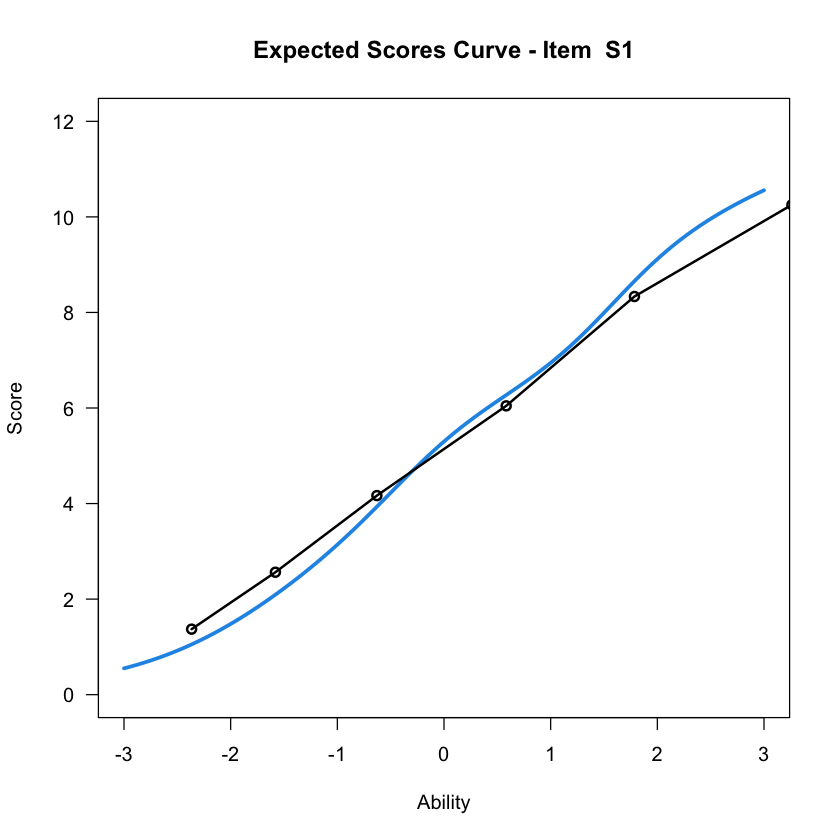

In [11]:
plot(pcm, items=113, type='expected', export=FALSE)

Iteration in WLE/MLE estimation  1   | Maximal change  2.3217 
Iteration in WLE/MLE estimation  2   | Maximal change  0.542 
Iteration in WLE/MLE estimation  3   | Maximal change  0.3915 
Iteration in WLE/MLE estimation  4   | Maximal change  0.1743 
Iteration in WLE/MLE estimation  5   | Maximal change  0.0349 
Iteration in WLE/MLE estimation  6   | Maximal change  0.0028 
Iteration in WLE/MLE estimation  7   | Maximal change  2e-04 
Iteration in WLE/MLE estimation  8   | Maximal change  0 
----
 WLE Reliability= 0.989 


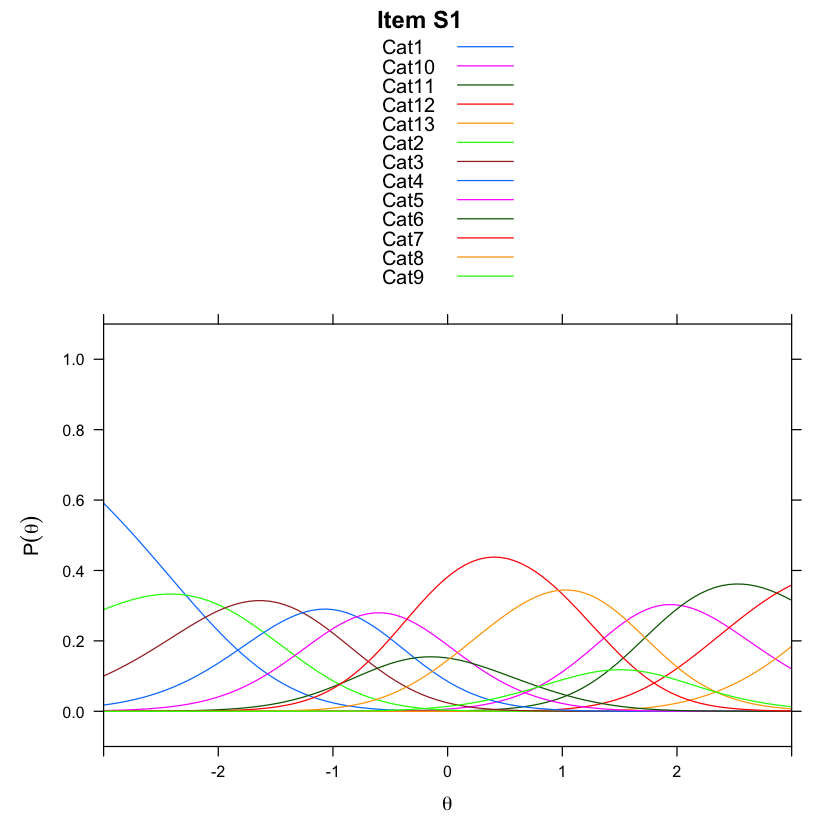

In [12]:
plot(pcm, items=113, type='items', export=FALSE)

Iteration in WLE/MLE estimation  1   | Maximal change  2.3217 
Iteration in WLE/MLE estimation  2   | Maximal change  0.542 
Iteration in WLE/MLE estimation  3   | Maximal change  0.3915 
Iteration in WLE/MLE estimation  4   | Maximal change  0.1743 
Iteration in WLE/MLE estimation  5   | Maximal change  0.0349 
Iteration in WLE/MLE estimation  6   | Maximal change  0.0028 
Iteration in WLE/MLE estimation  7   | Maximal change  2e-04 
Iteration in WLE/MLE estimation  8   | Maximal change  0 
----
 WLE Reliability= 0.989 


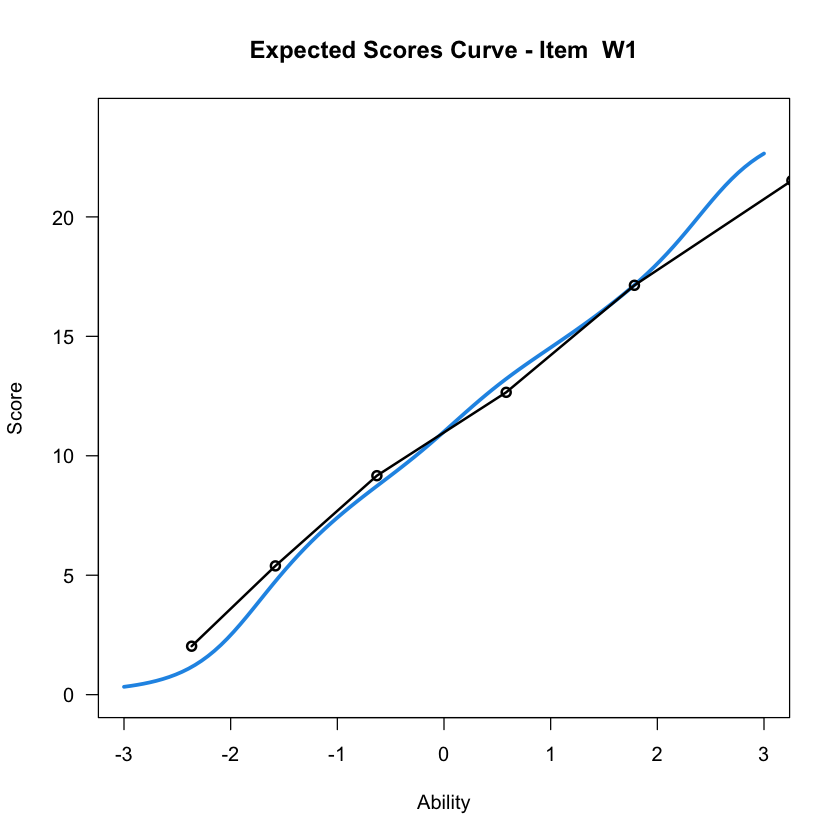

In [13]:
plot(pcm, items=123, type='expected', export=FALSE)

Iteration in WLE/MLE estimation  1   | Maximal change  2.3217 
Iteration in WLE/MLE estimation  2   | Maximal change  0.542 
Iteration in WLE/MLE estimation  3   | Maximal change  0.3915 
Iteration in WLE/MLE estimation  4   | Maximal change  0.1743 
Iteration in WLE/MLE estimation  5   | Maximal change  0.0349 
Iteration in WLE/MLE estimation  6   | Maximal change  0.0028 
Iteration in WLE/MLE estimation  7   | Maximal change  2e-04 
Iteration in WLE/MLE estimation  8   | Maximal change  0 
----
 WLE Reliability= 0.989 


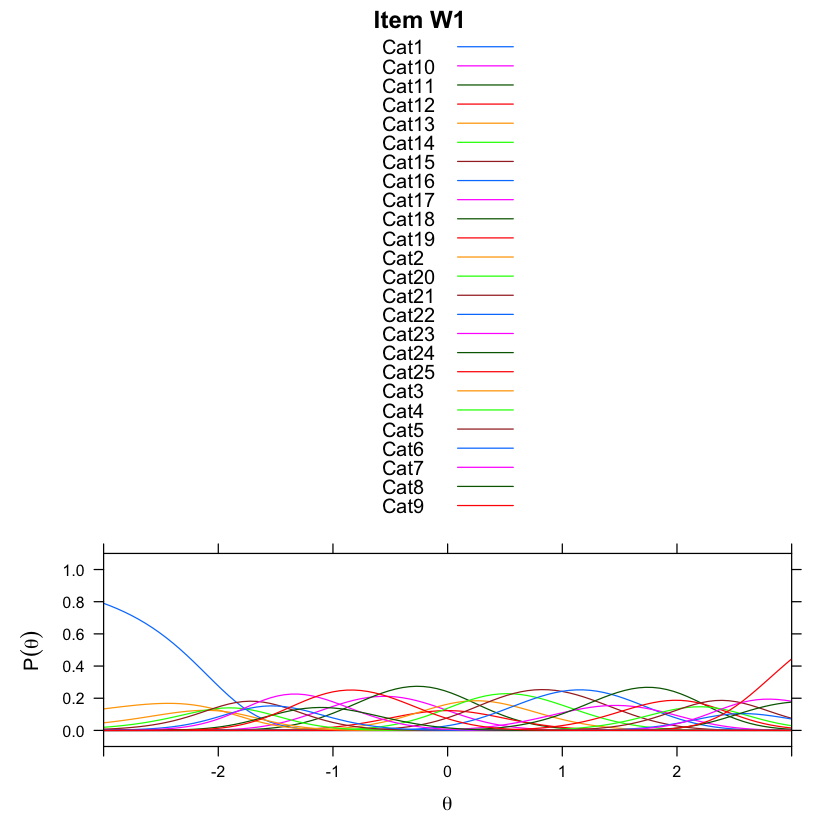

In [14]:
plot(pcm, items=123, type='items', export=FALSE)